<h3>Description</h3>

<b>This notebook demonstrates the feature selection process and a comparative analysis to evaluate model performance for each feature selection</b>

<b>This notebook is made according to the next instructions:</b>

1. Feature Selection based measurement:
- divide the data to train, validation, and test sets
- train a RF model with basic hyperparameters (max_depth = 4, trees = 100) on the train set
- fit explainability method (each one separately).
- for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the form of "feature impact" (aggregation of all local feature impact).
- apply absolute value on the global explanation results to get the feature importance for each XAI method.
- sort the list to have the order of the least to the most important features.
- start an iterative process of eliminating the least important feature in each iteration and store the evaluation on the train, validation, and test sets (train will be store for reporting) - for classification store accuracy, precision, recall, auc. regression - MSE, MAE
- programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). you can do that by applying argmax operation. iteration here = number of features to eliminate.
- visualization: 
* each line represents the test score w.r.t each evaluation metric in each iteration. 
* the arg max is the displayed red vertical line in the following figure.
* print the final score- this is the score over the test set.
- after applying the process for each XAI method you should display the test score side by side

<h3>Libraries import</h3>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from explainer_comparison.feature_eliminations import get_feature_elimination_results, add_best_feature_set, plot_feat_select_results
from explainer_comparison.constants import MODE

import matplotlib.pyplot as plt


<h3>Data preprocessing</h3>

In [2]:
# read a dataset
# df = pd.read_csv('../../data/diabetes/diabetes.csv')
df = pd.read_csv('../../data/german_credit_score/german_credit.csv')
# df = pd.read_csv('../../data/fico/train.csv')

# from sklearn.datasets import fetch_california_housing
# dataset_1 = fetch_california_housing(as_frame=True)
# X = dataset_1['data']
# y = dataset_1['target']

# random state
rs = 24

In [3]:
df.head()
# X.head()


,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [4]:
df.info()
# X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

In [5]:
# # for the fico ds fill missing values with an average value 
# for col in df.columns:
#     if df[col].isna().sum() > 0:
#         df[col].fillna(df[col].mean(), inplace=True)

In [6]:
# # for diabetes
# # data
# X = df.iloc[:, :-1]

# #target
# y = df.Outcome

# for german credit score
# data
X = df.iloc[:, 1:]
#target
y = df.Creditability

In [7]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_df = scaler.fit_transform(X)

# Convert back to a DataFrame
# normalized_df = pd.DataFrame(normalized_data, columns=numeric_features.columns)

In [8]:
X = pd.DataFrame(normalized_df, columns=X.columns)


In [9]:
# - divide the data to train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.5, random_state=1) #shuffle=False, 
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.4, random_state=1) #shuffle=False, 

X_train.shape, X_val.shape, X_test.shape

((500, 20), (300, 20), (200, 20))

<h3>Defining and training a model</h3>

In [10]:
# - train a RF model with basic hyperparameters (max_depth = 4, trees = 100) on the train set

# for diabetes, german_credit_score
model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=rs)

# # for california housing
# model = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=rs)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, random_state=24)

<h3>Feature selection demonstration</h3>

In [11]:
# - fit explainability method (each one separately).

# - for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the 
# form of "feature impact" (aggregation of all local feature impact).

# - apply absolute value on the global explanation results to get the feature importance for each XAI method.

# - sort the list to have the order of the least to the most important features.

# - start an iterative process of eliminating the least important feature in each iteration 
# and store the evaluation on the train, validation, and test sets (train will be store for reporting) - 
# for classification store accuracy, precision, recall, auc. regression - MSE, MAE

# choose mode: regression or classification

mode = MODE.CLASSIFICATION

# for california housing ds
# mode = MODE.REGRESSION

list_explainers = ['shap', 'lime', 'permutation_new', 'ebm'] # 'permutation', 

results_dict = get_feature_elimination_results(list_explainers, model, X_train, y_train, X_val, y_val, X_test, y_test,\
                                                            mode, threshold=0.3, random_state=rs, verbose=False)


SHAP


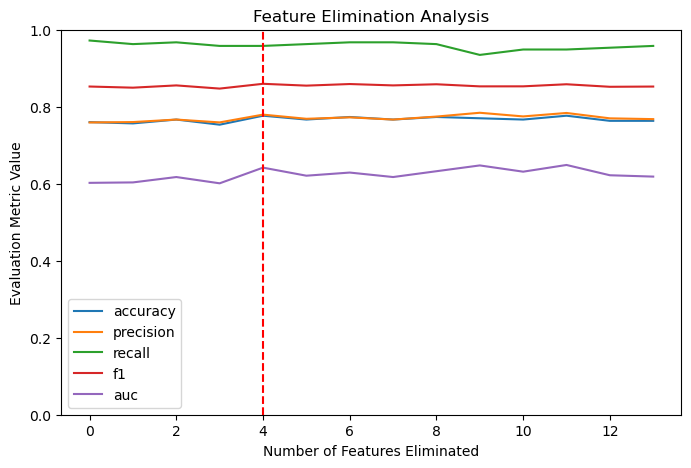

4 features are suggested to be removed
              train       val      test
accuracy   0.808000  0.776667  0.675000
precision  0.789474  0.779468  0.697802
recall     0.988539  0.957944  0.927007
f1         0.877863  0.859539  0.796238
auc        0.689634  0.641763  0.526996

LIME


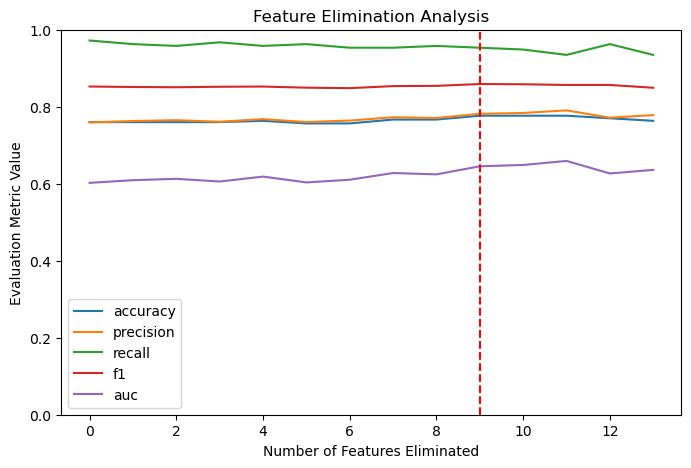

9 features are suggested to be removed
              train       val      test
accuracy   0.802000  0.776667  0.700000
precision  0.788018  0.781609  0.715084
recall     0.979943  0.953271  0.934307
f1         0.873563  0.858947  0.810127
auc        0.685336  0.645240  0.562391

PERMUTATION_NEW


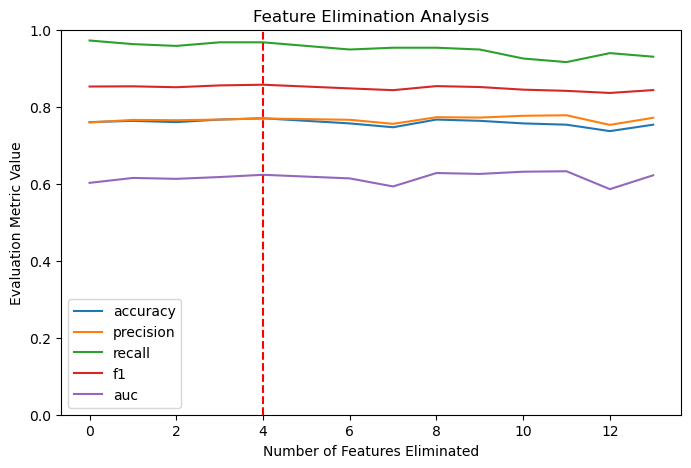

4 features are suggested to be removed
              train       val      test
accuracy   0.810000  0.770000  0.695000
precision  0.791284  0.769517  0.706522
recall     0.988539  0.967290  0.948905
f1         0.878981  0.857143  0.809969
auc        0.692945  0.623180  0.545881

EBM


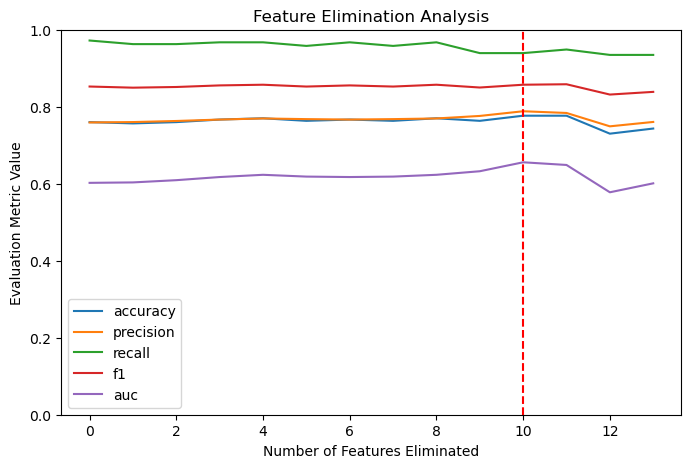

10 features are suggested to be removed
              train       val      test
accuracy   0.814000  0.776667  0.700000
precision  0.797674  0.788235  0.715084
recall     0.982808  0.939252  0.934307
f1         0.880616  0.857143  0.810127
auc        0.703325  0.655673  0.562391



In [12]:
# programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). 
# you can do that by applying argmax operation. iteration here = number of features to eliminate.

# - visualization: 
# * each line represents the test score w.r.t each evaluation metric in each iteration. 
# * the arg max is the displayed red vertical line in the following figure.

results_dict_upd = add_best_feature_set(results_dict, mode)

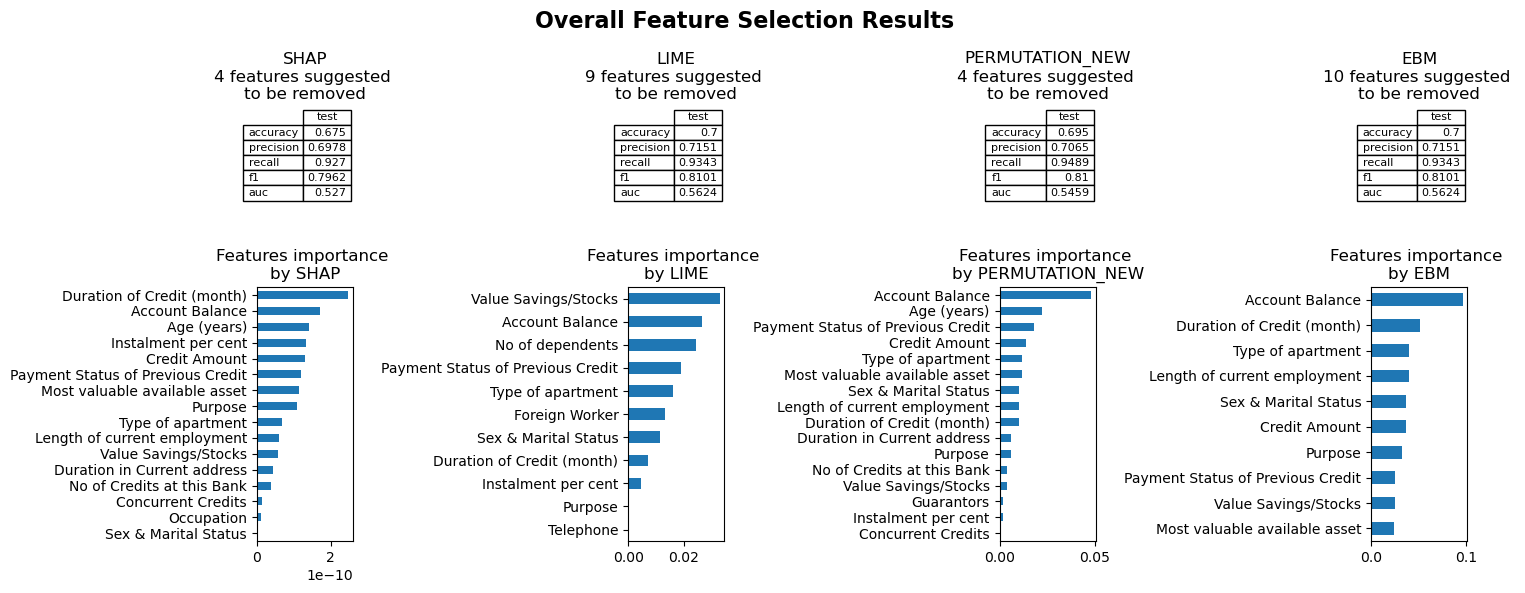

In [13]:
# * print the final score- this is the score over the test set.
# - after applying the process for each XAI method you should display the test score side by side

plot_feat_select_results(results_dict_upd)